<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/smc_tempered_1d_bimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustrate SMC with HMC kernel on a 1d bimodal distribution

Code is from
https://blackjax-devs.github.io/blackjax/examples/TemperedSMC.html


In [1]:
import jax
import os
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal
import seaborn as sns

jax.config.update("jax_platform_name", "cpu")

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq jaxopt blackjax
    import blackjax

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils.blackjax_utils import inference_loop
import blackjax.smc.resampling as resampling

In [2]:
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"

In [3]:
pml.latexify(width_scale_factor=2)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [4]:
FIG_SIZE = None if pml.is_latexify_enabled() else (12, 6)

# Target distribution

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


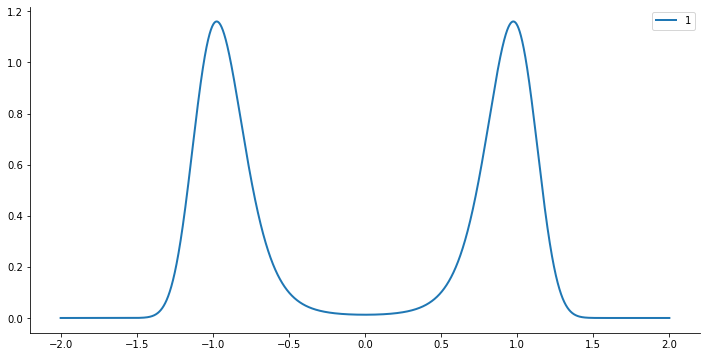

In [5]:
def V(x):
    return 5 * jnp.square(jnp.sum(x**2) - 1)


def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)
lambdas = jnp.array([1])
prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(lambdas, 1) * potential_vals.reshape(1, -1)

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (linspace[1] - linspace[0])
density /= normalizing_factor

fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot(linspace.squeeze(), density.T, lw=2)
ax.legend(list(lambdas))
sns.despine()
pml.savefig("bimodal-target")

# Tempered distribution

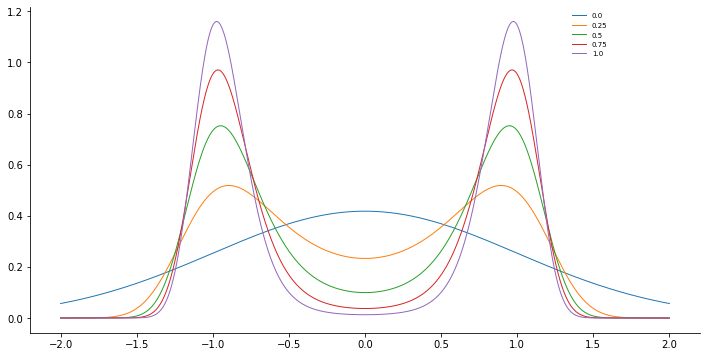

In [6]:
linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)
lambdas = jnp.linspace(0.0, 1.0, 5)
prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(lambdas, 1) * potential_vals.reshape(1, -1)

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (linspace[1] - linspace[0])
density /= normalizing_factor

fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot(linspace.squeeze(), density.T, lw=1)
ax.legend(list(lambdas), frameon=False, fontsize=7, bbox_to_anchor=(0.8, 1))
sns.despine()
pml.savefig("bimodal-tempered.pdf")

# HMC


In [7]:
def full_logprob(x):
    return -V(x) + prior_log_prob(x)


inv_mass_matrix = jnp.eye(1)
n_samples = 10_000

In [8]:
%%time
hmc = blackjax.hmc(full_logprob, step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=50)
initial_state = hmc.init(jnp.ones((1,)))
kernel = jax.jit(hmc.step)
key = jax.random.PRNGKey(42)
hmc_samples, hmc_info = inference_loop(key, kernel, initial_state, n_samples)

CPU times: user 1.38 s, sys: 30.1 ms, total: 1.41 s
Wall time: 1.37 s


(0.0, 4.663308943341834)


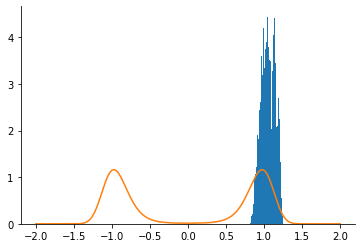

In [9]:
plt.figure()
_ = plt.hist(hmc_samples.position[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
sns.despine()
ylim = plt.ylim()
print(ylim)
pml.savefig("bimodal-hmc.pdf")

# NUTS

In [10]:
%%time
key = jax.random.PRNGKey(42)
nuts = blackjax.nuts(full_logprob, step_size=1e-4, inverse_mass_matrix=inv_mass_matrix)
initial_state = nuts.init(jnp.ones((1,)))
kernel = jax.jit(nuts.step)
nuts_samples, nuts_info = inference_loop(key, kernel, initial_state, n_samples)

CPU times: user 7.57 s, sys: 20.9 ms, total: 7.59 s
Wall time: 7.54 s


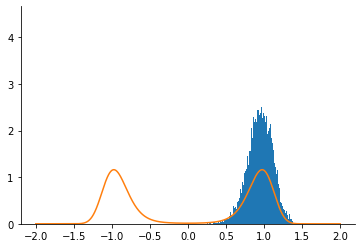

In [11]:
plt.figure()
_ = plt.hist(nuts_samples.position[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
sns.despine()
plt.gca().set_ylim(ylim)
pml.savefig("bimodal-nuts.pdf")

# SMC

In [12]:
def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(cond, one_step, (0, initial_state, rng_key))

    return n_iter, final_state

In [13]:
%%time

loglikelihood = lambda x: -V(x)

hmc_parameters = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1)

tempered = blackjax.adaptive_tempered_smc(
    prior_log_prob,
    loglikelihood,
    blackjax.hmc,
    hmc_parameters,
    resampling.systematic,
    0.5,
    mcmc_iter=1,
)

initial_smc_state = jax.random.multivariate_normal(jax.random.PRNGKey(0), jnp.zeros([1]), jnp.eye(1), (n_samples,))
initial_smc_state = tempered.init(initial_smc_state)

n_iter, smc_samples = smc_inference_loop(key, tempered.step, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", n_iter.item())

Number of steps in the adaptive algorithm:  9
CPU times: user 3.17 s, sys: 2.34 s, total: 5.5 s
Wall time: 2.63 s


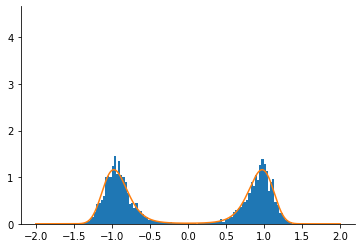

In [14]:
plt.figure()
samples = jnp.array(smc_samples.particles[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
sns.despine()
plt.gca().set_ylim(ylim)
pml.savefig("bimodal-smc-tempered")

# SMC modified

We change the code to track the temperature at each step.
But first we illustrate how to append to a list inside jax while loop. The trick is to use a fixed-size buffer.


In [15]:
def cond_fun(val):
    i, buffer = val
    return i < 5


def body_fun(val):
    i, buffer = val
    i = i + 1
    cur = buffer["current"]
    buffer["data"] = buffer["data"].at[cur].set(i)
    buffer["current"] = cur + 1
    return (i, buffer)


buffer_size = 100
buffer = {"data": jnp.zeros((buffer_size,)), "current": 0}
init_val = (0.0, buffer)
_, buffer = jax.lax.while_loop(cond_fun, body_fun, init_val)
print(buffer)

{'current': DeviceArray(5, dtype=int32, weak_type=True), 'data': DeviceArray([1., 2., 3., 4., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}


If necessary, we can grow the buffer on demand.

In [16]:
def cond_fun(val):
    i, buffer = val
    return (i < 5) & (buffer["current"] < buffer_size)


def body_fun(val):
    i, buffer = val
    i = i + 1
    cur = buffer["current"]
    buffer["data"] = buffer["data"].at[cur].set(i)
    buffer["current"] = cur + 1
    return (i, buffer)


buffer_size = 3
intermediates = []
i = 0.0
while i < 5:
    buffer = {"data": jnp.zeros((buffer_size,)), "current": 0}
    i, buffer = jax.lax.while_loop(cond_fun, body_fun, (i, buffer))
    intermediates += [buffer["data"]]

print(jnp.concatenate(intermediates))

[1. 2. 3. 4. 5. 0.]


Now we return to SMC.


In [17]:
def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, key, buffer = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, key, buffer = carry
        key, subk = jax.random.split(key, 2)
        state, _ = smc_kernel(subk, state)
        # lambdas.append(state.lmbda)
        cur = buffer["current"]
        buffer["data"] = buffer["data"].at[cur].set(state.lmbda)
        # buffer['data'] = buffer['data'].at[cur].set(i)
        buffer["current"] = cur + 1
        return i + 1, state, key, buffer

    # lambdas = []
    # use fixed size array to keep track of lambdas
    buffer_size = 100
    buffer = {"data": jnp.zeros((buffer_size,)), "current": 0}
    n_iter, final_state, key, buffer = jax.lax.while_loop(cond, one_step, (0, initial_state, rng_key, buffer))

    return n_iter, final_state, buffer["data"][:n_iter]

In [18]:
%%time
key = jax.random.PRNGKey(42)
loglikelihood = lambda x: -V(x)

hmc_parameters = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1)

tempered = blackjax.adaptive_tempered_smc(
    prior_log_prob,
    loglikelihood,
    blackjax.hmc,
    hmc_parameters,
    resampling.systematic,
    0.5,
    mcmc_iter=1,
)

initial_smc_state = jax.random.multivariate_normal(jax.random.PRNGKey(0), jnp.zeros([1]), jnp.eye(1), (n_samples,))
initial_smc_state = tempered.init(initial_smc_state)

n_iter, smc_samples, lambdas = smc_inference_loop(key, tempered.step, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", n_iter.item())

Number of steps in the adaptive algorithm:  9
CPU times: user 3.24 s, sys: 3.25 s, total: 6.49 s
Wall time: 2.57 s


In [19]:
print(lambdas)

[0.00538135 0.01532254 0.04021941 0.08235608 0.15540347 0.2983744
 0.5712157  0.9644599  1.        ]


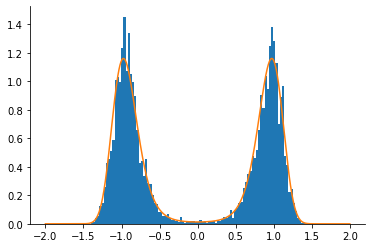

In [20]:
_ = plt.hist(smc_samples.particles[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
sns.despine()

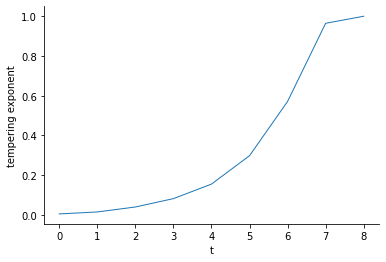

In [21]:
plt.figure()
plt.plot(lambdas, lw=1)
plt.xlabel("t")
plt.ylabel("tempering exponent")
sns.despine()
pml.savefig("bimodal-smc-exponent-vs-time.pdf")

In [22]:
smc_samples

TemperedSMCState(particles=DeviceArray([[ 1.1464324 ],
             [ 1.1464324 ],
             [-1.1070769 ],
             ...,
             [ 0.57004714],
             [ 0.70350933],
             [ 0.7039775 ]], dtype=float32), lmbda=DeviceArray(1., dtype=float32, weak_type=True))

Let's track the adaptive temperature.
 

In [23]:
smc_samples.particles.shape

(10000, 1)